In [1]:
%reload_ext autoreload
%autoreload 2

import os
import shutil
import numpy as np
from scipy import stats
from tqdm import tqdm

import py21cmfish
from py21cmfish.power_spectra import *
from py21cmfish.io import *

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/dm21cm/lib/python3.11/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")


## 1. 21cmFISH standard astrophysics

In [ ]:
noise_dir = '/n/home07/yitians/dm21cm/21cmSense_fid_EOS21/'
data_dir = '/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/bkg/LightCones/'


astro_params_vary = ['DM', 'F_STAR10', 'F_STAR7_MINI', 'ALPHA_STAR', 'ALPHA_STAR_MINI', 't_STAR',
                     'F_ESC10', 'F_ESC7_MINI', 'ALPHA_ESC', 'L_X', 'L_X_MINI', 'NU_X_THRESH', 'A_LW']
default_param_values = [0, -1.25, -2.5, 0.5, 0.0, 0.5, -1.35, -1.35, -0.3, 40.5, 40.5, 500, 2.0]

astro_params_vary = list(np.array(astro_params_vary))
default_param_values = default_param_values
astro_params_fid = dict()
for i in range(len(astro_params_vary)):
    astro_params_fid[astro_params_vary[i]] = default_param_values[i]
    
# Load each parameter into a dictionary
params_EoS = {}

for param in astro_params_vary[1:]:
    params_EoS[param] = py21cmfish.Parameter(
        HII_DIM=128, BOX_LEN=256, param=param,
        output_dir = data_dir,
        PS_err_dir = noise_dir,
        new = False
)

## 2. Fisher analysis at each mass

In [12]:
#log10m_PBH_s = np.array([14.25, 14.5, 14.75, 15., 15.5, 16., 16.5, 17., 17.5, 18.])
log10m_PBH_s = np.array([13.25, 13.75])
m_PBH_s = 10 ** log10m_PBH_s # [g]
#f_PBH_s = 10 ** (3.5 * np.log10(m_PBH_s) - 63) # [1]

x = np.log10(m_PBH_s)
x0 = 14.75
est0_s = 10 ** (3.5 * x - 63)
est1_s = 10 ** (3.5 * x - 63 + 1.5 * (x-x0)**4 *(x<x0))
est_s = np.where(x < 14.25, est1_s, est0_s)

f_PBH_s = est_s

mass_s = m_PBH_s
inj_s = f_PBH_s

In [4]:
inj_dir = '/n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/pbh'
os.listdir(inj_dir)

['log10m18.000',
 'log10m14.500',
 'log10m15.000',
 'old',
 'log10m16.500',
 'log10m14.750',
 'log10m14.250',
 'log10m13.750',
 'log10m13.250',
 'log10m16.000',
 'log10m15.500',
 'log10m17.000',
 'log10m17.500']

In [6]:
# Gotta put the fiducial lightcone in each mass directory
for m in mass_s:
    source_file = f'{data_dir}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    target_file = f'{inj_dir}/log10m{np.log10(m):.3f}/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5'
    if not os.path.isfile(f'{inj_dir}/log10m{np.log10(m):.3f}'):
        shutil.copyfile(source_file, target_file)
        print(f'Copied {source_file} to {target_file}')

Copied /n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/bkg/LightCones//LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5 to /n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/pbh/log10m13.250/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5
Copied /n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/bkg/LightCones//LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5 to /n/holylabs/LABS/iaifi_lab/Users/yitians/dm21cm/outputs/pbh/log10m13.750/LightCone_z5.0_HIIDIM=128_BOXLEN=256_fisher_fid_r54321.h5


In [ ]:
sigma_s = []

for m in mass_s:
    print(f'\n\nNow processing m={m:.3e}\n\n')

    lc_dir = f'{inj_dir}/log10m{np.log10(m):.3f}/'
    new = 'lc_redshifts.npy' not in os.listdir(lc_dir)
    
    for param in astro_params_vary[:1]:
        params_EoS[param] = py21cmfish.Parameter(
            HII_DIM=128, BOX_LEN=256, param=param,
            output_dir=lc_dir,
            PS_err_dir=noise_dir, new=new,
        )

    Fij_matrix_PS, Finv_PS= py21cmfish.make_fisher_matrix(
        params_EoS,
        fisher_params=astro_params_vary,
        hpeak=0.0, obs='PS',
        k_min=0.1, k_max=1,
        sigma_mod_frac=0.2,
        add_sigma_poisson=True
    )
    sigma_s.append(np.sqrt(Finv_PS[0, 0]))
    
sigma_s = np.array(sigma_s)

In [8]:
sigma_s

array([ 68.41883704, 145.49185935])

[Text(0.5, 0, '$M$ [g]'), Text(0, 0.5, '$f$')]

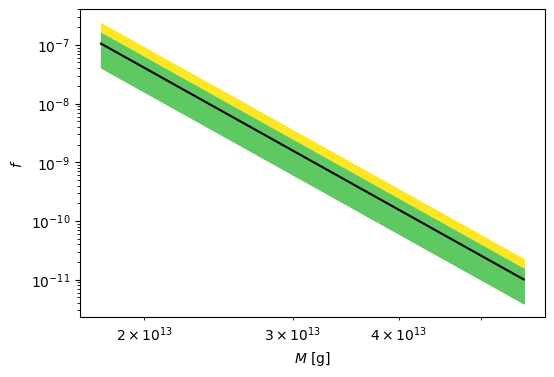

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

one_sigma = inj_s * sigma_s
upper_limit = np.sqrt(stats.chi2.ppf(.9, df=1)) * one_sigma

ax.plot(mass_s, upper_limit, 'k')
ax.fill_between(mass_s, upper_limit + one_sigma, upper_limit - one_sigma, color=mpl.colormaps['viridis'](0.75))
ax.fill_between(mass_s, upper_limit + 2*one_sigma, upper_limit + one_sigma, color=mpl.colormaps['viridis'](1.0))

ax.set(xscale='log', yscale='log')
ax.set(xlabel=r'$M$ [g]', ylabel=r'$f$')

In [14]:
np.savetxt('../outputs/limits/pbh_limits_tmp.txt', np.array([mass_s, inj_s, sigma_s]).T, header='mass_s inj_s sigma_s')